# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Xoai/gia_xoai_thoi_tiet.csv"

In [3]:
var_file_name = 'var_gia_cam_thoi_tiet.joblib'
varma_file_name = 'varma_cam_lua_thoi_tiet.joblib'


## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

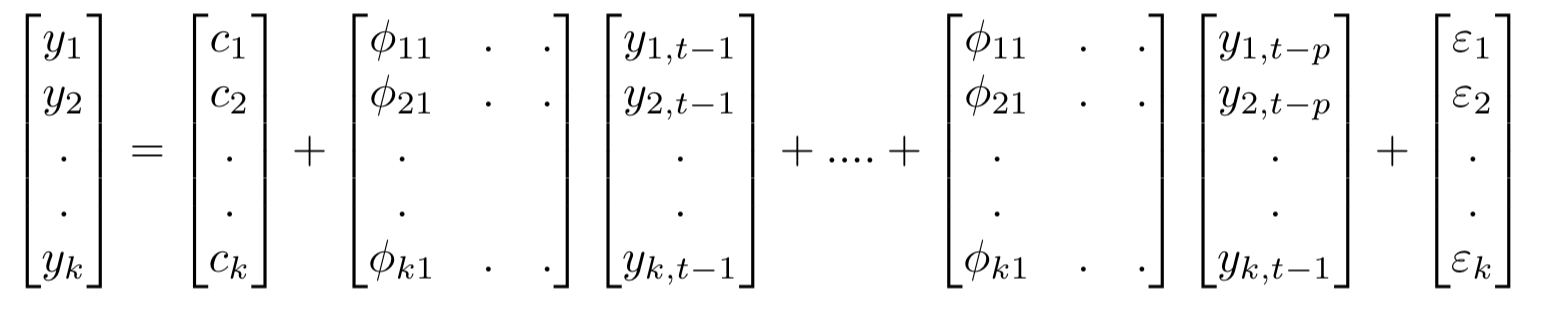

In [4]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [5]:
df.set_index('date', inplace=True)

In [6]:
df.head()

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
date,,,,,,,,
2014-11-20,18000,82.6,77.0,89.6,0.268,24.0,3.1,1011.0
2014-11-27,18000,82.8,75.2,91.4,0.268,24.0,3.1,1011.0
2014-12-04,18000,83.5,77.0,89.6,0.268,24.0,6.1,1011.0
2014-12-11,18000,82.0,75.2,87.8,0.268,24.0,7.8,1011.0
2014-12-25,18000,83.8,75.2,91.4,0.268,143.0,3.4,1011.0


<Axes: >

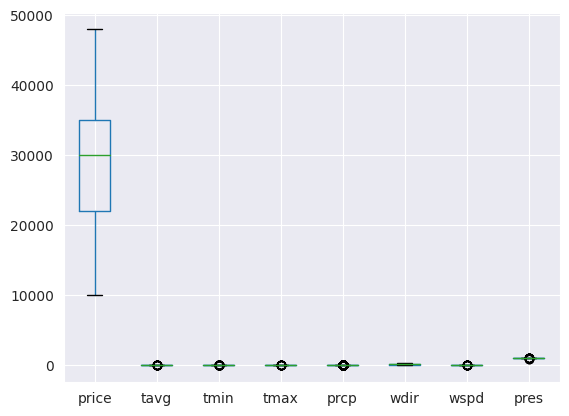

In [7]:
df.boxplot()

In [8]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 0


<Axes: >

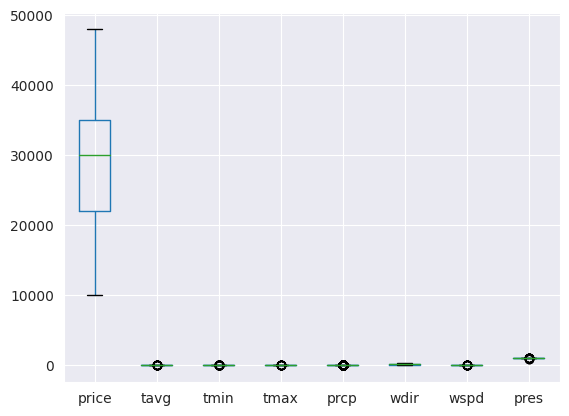

In [9]:
df.boxplot()

In [10]:
df = df.dropna()

In [11]:
fillter_feature = ['price', 'tavg', 'tmax', 'pres']
df = df[fillter_feature]

In [12]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,tavg,tmax,pres
price,1.000000,-0.059021,-0.040019,0.009254
tavg,-0.059021,1.000000,0.821103,-0.030529
tmax,-0.040019,0.821103,1.000000,0.103548
pres,0.009254,-0.030529,0.103548,1.000000


In [13]:
from google.colab import files
df.to_csv('./gia_xoai_thoi_tiet.csv')
files.download('./gia_xoai_thoi_tiet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: xlabel='date'>

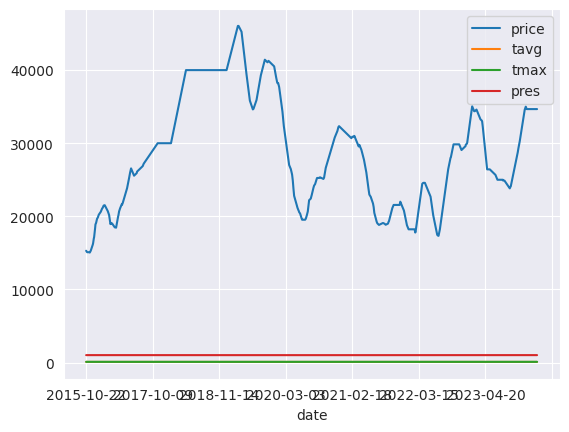

In [ ]:
df = df.rolling(45).mean()
df = df.dropna()
df.plot()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,tavg,tmax,pres
price,1.000000,-0.137935,-0.110672,0.046027
tavg,-0.137935,1.000000,0.946139,-0.008605
tmax,-0.110672,0.946139,1.000000,0.210437
pres,0.046027,-0.008605,0.210437,1.000000


In [ ]:
from google.colab import files
df.to_csv('./gia_xoai_thoi_tiet.csv')
files.download('./gia_xoai_thoi_tiet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
nobs = int(len(df)*0.7)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(949, 4)
(407, 4)


In [ ]:
from google.colab import files


## Kiểm tra stationary

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.3358
 No. Lags Chosen       = 5
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.1607. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5611
 No. Lags Chosen       = 10
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tmax" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


In [ ]:
df_differenced = df_train.diff().dropna()

In [ ]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0526
 No. Lags Chosen       = 0
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4002
 No. Lags Chosen       = 7
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tmax" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

## Train model

In [ ]:
model = VAR(df_differenced)
for i in range(1, 50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -8.76542299756482
BIC :  -8.66292460066543
FPE :  0.00015603618771751077
HQIC:  -8.726363645684104 

Lag Order = 2
AIC :  -8.84296583818867
BIC :  -8.658313901100016
FPE :  0.00014439419375101293
HQIC:  -8.772596418912931 

Lag Order = 3
AIC :  -8.875045461465902
BIC :  -8.608101952228152
FPE :  0.00013983624222516547
HQIC:  -8.773310172131772 

Lag Order = 4
AIC :  -8.881946803403858
BIC :  -8.532573308384903
FPE :  0.00013887570598788344
HQIC:  -8.748789683074717 

Lag Order = 5
AIC :  -8.878244134225449
BIC :  -8.446301856663188
FPE :  0.0001393928049991648
HQIC:  -8.713609063078465 

Lag Order = 6
AIC :  -8.88704491065875
BIC :  -8.372394669196291
FPE :  0.000138174242432828
HQIC:  -8.690875609368904 

Lag Order = 7
AIC :  -8.8846330289991
BIC :  -8.287135256212803
FPE :  0.000138511814777238
HQIC:  -8.656873058120176 

Lag Order = 8
AIC :  -8.885903716695664
BIC :  -8.205418457616032
FPE :  0.0001383410904762452
HQIC:  -8.626496476038218 

Lag Order = 9
AIC : 

In [ ]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,-5.642,-5.620,0.003547,-5.633
1,-8.804,-8.697*,0.0001502,-8.763
2,-8.874,-8.682,0.0001399,-8.801*
3,-8.904,-8.626,0.0001358,-8.798
4,-8.909,-8.545,0.0001352,-8.770
5,-8.902,-8.453,0.0001362,-8.730
6,-8.911,-8.376,0.0001350,-8.706
7,-8.910,-8.290,0.0001350,-8.673
8,-8.914,-8.209,0.0001345,-8.645
9,-8.921,-8.130,0.0001336,-8.619


In [ ]:
model_var = model.fit(46)
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Jun, 2024
Time:                     10:23:21
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -5.92058
Nobs:                     902.000    HQIC:                  -8.35669
Log likelihood:           68.3604    FPE:                5.33477e-05
AIC:                     -9.86229    Det(Omega_mle):     2.52944e-05
--------------------------------------------------------------------
Results for equation price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.171384         1.413691           -0.121           0.904
L1.price          0.992674         0.032730           30.329           0.000
L1.tavg         -20.592038        47.282614           -0.436           0.663

In [ ]:
def adjust(val, length= 6): return str(val).ljust(length)

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.01
tavg   : 2.02
tmax   : 2.03
pres   : 2.02


In [ ]:
# Get the lag order
lag_order = model_var.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

46


array([[ 2.22222222e+01,  1.00000000e-01,  2.00000000e-01,
         0.00000000e+00],
       [ 2.22222222e+01,  1.33333333e-02,  1.60000000e-01,
         2.22222222e-02],
       [ 2.22222222e+01,  4.00000000e-02,  8.00000000e-02,
         4.44444444e-03],
       [ 2.22222222e+01, -6.00000000e-02, -4.00000000e-02,
        -1.33333333e-02],
       [ 2.22222222e+01, -1.06666667e-01, -4.00000000e-02,
         3.33333333e-02],
       [ 1.33333333e+02, -8.00000000e-02, -8.00000000e-02,
        -4.44444444e-03],
       [ 1.33333333e+02, -6.00000000e-02, -8.00000000e-02,
         1.11111111e-02],
       [ 6.66666667e+01,  1.11111111e-02, -4.00000000e-02,
         5.11111111e-02],
       [ 1.77777778e+02, -2.88888889e-02,  4.00000000e-02,
         0.00000000e+00],
       [ 1.77777778e+02, -4.44444444e-02, -1.60000000e-01,
         2.00000000e-02],
       [ 1.77777778e+02,  2.44444444e-02,  0.00000000e+00,
         5.11111111e-02],
       [ 1.77777778e+02, -1.55555556e-02,  4.00000000e-02,
      

In [ ]:
# Forecast
nobs = len(df_test)
fc = model_var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,price_2d,tavg_2d,tmax_2d,pres_2d
date,,,,
2021-11-11,-72.145498,0.019227,-0.057614,0.003945
2021-11-12,-60.684247,0.032877,0.011114,0.077249
2021-11-15,-52.365521,0.087446,0.076988,0.047162
2021-11-16,-64.622443,0.077390,0.037620,0.007020
2021-11-17,-121.644397,0.088600,0.093699,0.025651
...,...,...,...,...
2024-02-28,-2.731268,-0.000273,-0.000028,-0.004159
2024-02-29,-1.317663,-0.000860,0.000206,0.000137
2024-03-04,-4.906343,-0.002538,-0.002005,-0.005450


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+ '_2d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['price_forecast']]

,price_forecast
date,
2021-11-11,21483.410058
2021-11-12,21422.725811
2021-11-15,21370.360290
2021-11-16,21305.737847
2021-11-17,21184.093450
...,...
2024-02-28,18568.229452
2024-02-29,18566.911789
2024-03-04,18562.005446


### Đánh giá mô hình VAR

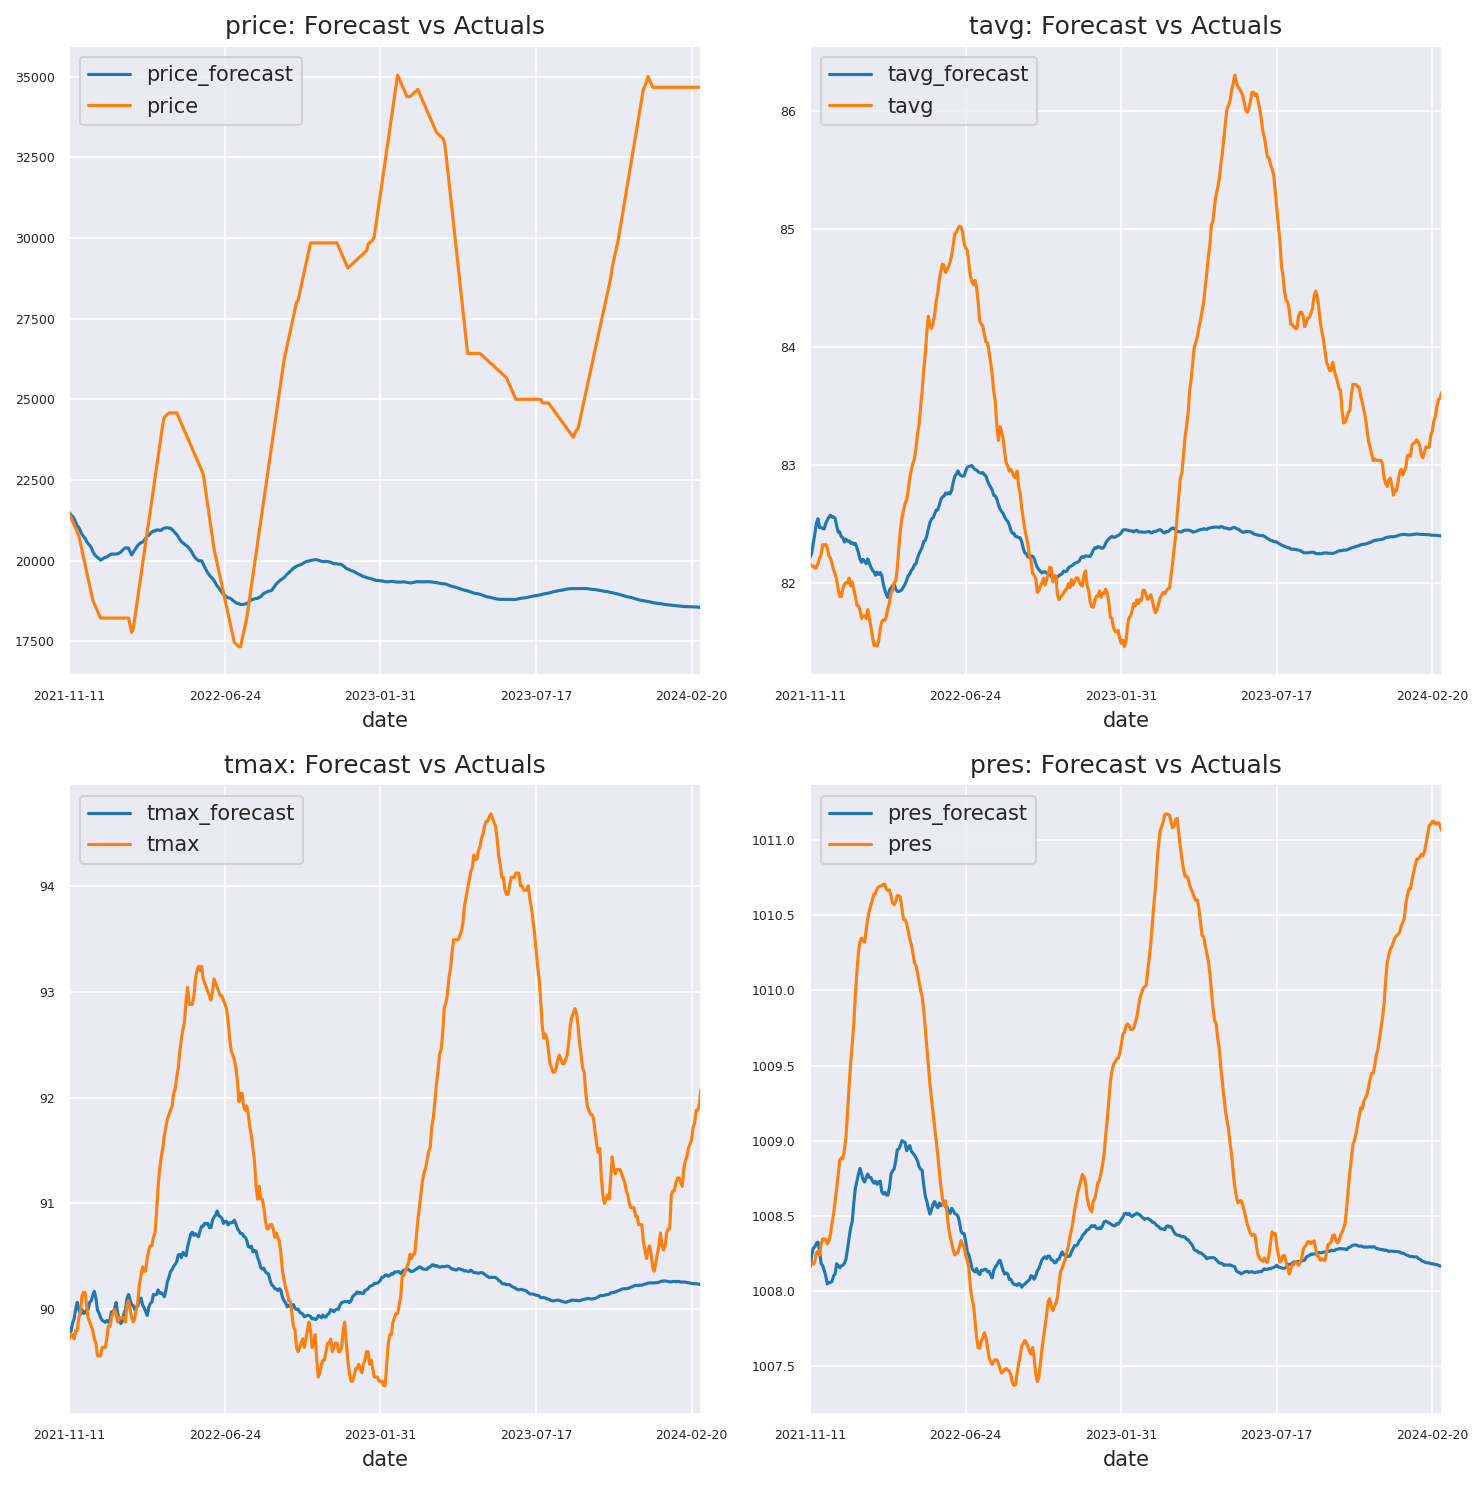

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100 # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [ ]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  25.8385
rmse   :  9150.8488


In [ ]:
import joblib
joblib.dump(model_var, var_file_name)
from google.colab import files
files.download(var_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## VARMA Model

Mô hình Vector Autoregressive Moving Average (VARMA) là sự kết hợp của mô hình VAR và mô hình VMA, giúp trong việc mô hình hóa chuỗi thời gian đa biến bằng cách xem xét cả thứ tự của lag và thứ tự của trung bình di chuyển (p và q) trong mô hình.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.0 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
columns_train = fillter_feature

In [ ]:
# pq = []
# for name, column in df_differenced[columns_train].items():
#     print(f'Searching order of p and q for : {name}')
#     stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
#         trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
#     parameter = stepwise_model.get_params().get('order')
#     print(f'optimal order for:{name} is: {parameter} \n\n')
#     pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : price
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10207.167, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10214.930, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10215.263, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10215.028, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10212.931, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10208.718, Time=2.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10208.708, Time=1.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10212.474, Time=0.92 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10213.452, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10208.368, Time=3.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10205.168, Time=1.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10213.026, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10213.263, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10206

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-81745a528ff9>", line 4, in <cell line: 2>
    stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py", line 701, in auto_arima
    sorted_res = search.solve()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 405, in solve
    self._do_fit((p, d, q + 1), (P, D, Q, m)):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 235, in _do_fit
    fit, fit_time, new_ic = self._fit_arima(
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdari

TypeError: object of type 'NoneType' has no len()

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

In [ ]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
# df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
# print('Grid Search Started')
# for i in pq:
#     if i[0]== 0 and i[2] ==0:
#         pass
#     else:
#         print(f' Running for {i}')
#         model = VARMAX(df_differenced[columns_train], order=(i[0],i[2])).fit( disp=False)
#         result = model.forecast(steps = 30)
#         inv_res = inverse_diff(df_train[columns_train], result)
#         Opensrmse = np.sqrt(metrics.mean_squared_error(df_test['price'][:30], inv_res['price_forecast']))

#         print(({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse}))


In [ ]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model_varma = VARMAX(df_differenced[columns_train], order=(3,3),trends = 'n').fit( disp=False)


In [ ]:
len(df_test)

407

In [ ]:
result = model_varma.forecast(30)

In [ ]:
inv_res = inverse_diff(df_test[columns_train], result)

Đánh giá mô hình

In [ ]:
accuracy_prod = forecast_accuracy(inv_res['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  22.957
rmse   :  8104.5719


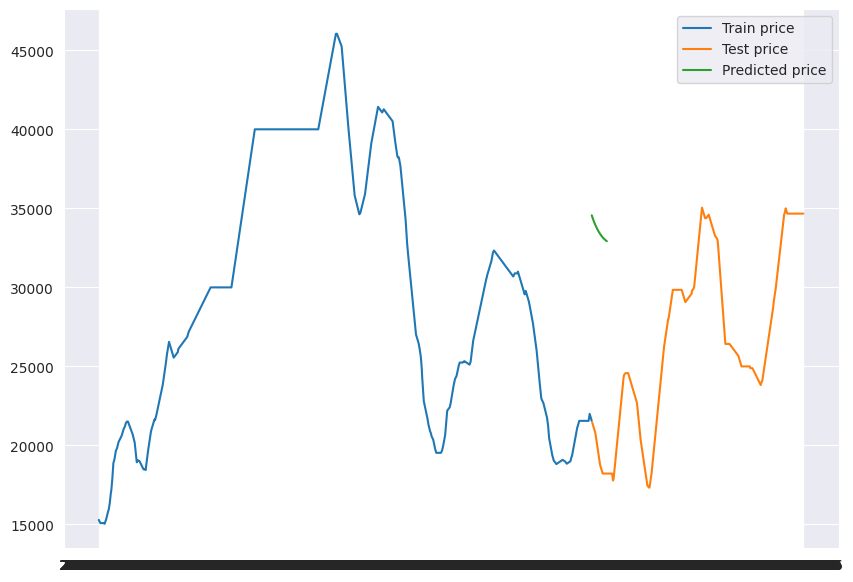

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(inv_res[str(i)+'_forecast'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [ ]:
import joblib
from google.colab import drive

var_file_name = "var_gia_xoai_thoi_tiet.joblib"
varma_file_name = "varma_gia_xoai_thoi_tiet.joblib"
drive.mount('/content/drive')

joblib.dump(model_varma, '/content/drive/MyDrive/model/' + varma_file_name)


joblib.dump(model_var, '/content/drive/MyDrive/model/' + var_file_name)

MessageError: Error: credential propagation was unsuccessful